# Dropout

In this notebook, you will implement dropout.  Then we will ask you to train a network with batchnorm and dropout, and acheive over 55% accuracy on CIFAR-10.

CS231n has built a solid API for building these modular frameworks and training them, and we will use their very well implemented framework as opposed to "reinventing the wheel."  This includes using their Solver, various utility functions, and their layer structure.  This also includes nndl.fc_net, nndl.layers, and nndl.layer_utils.  As in prior assignments, we thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  

In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [1]:
cd /content/gdrive/My Drive/Colab Notebooks/ee247/HW4-code/

[Errno 2] No such file or directory: '/content/gdrive/My Drive/Colab Notebooks/ee247/HW4-code/'
/content


In [0]:
## Import and setups

import time
import numpy as np
import matplotlib.pyplot as plt
from nndl.fc_net import *
from nndl.layers import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [0]:
cd /content/gdrive/My Drive/Colab Notebooks/ee247/

/content/gdrive/My Drive/Colab Notebooks/ee247


In [0]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k in data.keys():
    print('{}: {} '.format(k, data[k].shape))

X_train: (49000, 3, 32, 32) 
y_train: (49000,) 
X_val: (1000, 3, 32, 32) 
y_val: (1000,) 
X_test: (1000, 3, 32, 32) 
y_test: (1000,) 


## Dropout forward pass

Implement the training and test time dropout forward pass, `dropout_forward`, in `nndl/layers.py`. After that, test your implementation by running the following cell.

In [0]:
x = np.random.randn(500, 500) + 10

for p in [0.3, 0.6, 0.75]:
    out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
    out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

    print('Running tests with p = ', p)
    print('Mean of input: ', x.mean())
    print('Mean of train-time output: ', out.mean())
    print('Mean of test-time output: ', out_test.mean())
    print('Fraction of train-time output set to zero: ', (out == 0).mean())
    print('Fraction of test-time output set to zero: ', (out_test == 0).mean())

Running tests with p =  0.3
Mean of input:  10.000206319998307
Mean of train-time output:  10.000206319998307
Mean of test-time output:  10.000206319998307
Fraction of train-time output set to zero:  0.0
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.6
Mean of input:  10.000206319998307
Mean of train-time output:  10.000206319998307
Mean of test-time output:  10.000206319998307
Fraction of train-time output set to zero:  0.0
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.75
Mean of input:  10.000206319998307
Mean of train-time output:  10.000206319998307
Mean of test-time output:  10.000206319998307
Fraction of train-time output set to zero:  0.0
Fraction of test-time output set to zero:  0.0


## Dropout backward pass

Implement the backward pass, `dropout_backward`, in `nndl/layers.py`.  After that, test your gradients by running the following cell:

In [0]:
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  1.8928970356118117e-11


## Implement a fully connected neural network with dropout layers

Modify the `FullyConnectedNet()` class in `nndl/fc_net.py` to incorporate dropout.  A dropout layer should be incorporated after every ReLU layer.  Concretely, there shouldn't be a dropout at the output layer since there is no ReLU at the output layer. You will need to modify the class in the following areas:

(1) In the forward pass, you will need to incorporate a dropout layer after every relu layer.

(2) In the backward pass, you will need to incorporate a dropout backward pass layer.

Check your implementation by running the following code.  Our W1 gradient relative error is on the order of 1e-6 (the largest of all the relative errors).

In [0]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0.5, 0.75, 1.0]:
    print('Running check with dropout = ', dropout)
    model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                              weight_scale=5e-2, dtype=np.float64,
                              dropout=dropout, seed=123)

    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('{} relative error: {}'.format(name, rel_error(grad_num, grads[name])))
    print('\n')

Running check with dropout =  0.5
Initial loss:  2.3051948273987857
W1 relative error: 2.5272575344376073e-07
W2 relative error: 1.5034484929313676e-05
W3 relative error: 2.753446833630168e-07
b1 relative error: 2.936957476400148e-06
b2 relative error: 5.051339805546953e-08
b3 relative error: 1.1740467838205477e-10


Running check with dropout =  0.75
Initial loss:  2.302393230564104
W1 relative error: 3.386975992810743e-07
W2 relative error: 2.241789189885794e-07
W3 relative error: 1.9653893864322086e-07
b1 relative error: 3.684082803289692e-08
b2 relative error: 5.465218756779831e-09
b3 relative error: 7.539531964666713e-11


Running check with dropout =  1.0
Initial loss:  2.3013464380943134
W1 relative error: 1.2920002811595769e-07
W2 relative error: 3.9503910204631417e-07
W3 relative error: 4.279464253510945e-07
b1 relative error: 6.9916830773784215e-09
b2 relative error: 2.8231394334616772e-09
b3 relative error: 8.934289674335329e-11




## Dropout as a regularizer

In class, we claimed that dropout acts as a regularizer by effectively bagging.  To check this, we will train two small networks, one with dropout and one without dropout.  

In [0]:
# Train two identical nets, one with dropout and one without

num_train = 500
small_data = {
    'X_train': data['X_train'][:num_train],
    'y_train': data['y_train'][:num_train],
    'X_val': data['X_val'],
    'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0.6, 1.0]
for dropout in dropout_choices:
    model = FullyConnectedNet([100, 100, 100], dropout=dropout)

    solver = Solver(model, small_data,
                    num_epochs=25, batch_size=100,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': 5e-4,
                    },
                    verbose=True, print_every=100)
    solver.train()
    solvers[dropout] = solver

(Iteration 1 / 125) loss: 2.301994
(Epoch 0 / 25) train acc: 0.142000; val_acc: 0.157000
(Epoch 1 / 25) train acc: 0.262000; val_acc: 0.254000
(Epoch 2 / 25) train acc: 0.316000; val_acc: 0.266000
(Epoch 3 / 25) train acc: 0.336000; val_acc: 0.275000
(Epoch 4 / 25) train acc: 0.392000; val_acc: 0.288000
(Epoch 5 / 25) train acc: 0.402000; val_acc: 0.295000
(Epoch 6 / 25) train acc: 0.460000; val_acc: 0.311000
(Epoch 7 / 25) train acc: 0.502000; val_acc: 0.294000
(Epoch 8 / 25) train acc: 0.524000; val_acc: 0.316000
(Epoch 9 / 25) train acc: 0.606000; val_acc: 0.296000
(Epoch 10 / 25) train acc: 0.646000; val_acc: 0.298000
(Epoch 11 / 25) train acc: 0.676000; val_acc: 0.311000
(Epoch 12 / 25) train acc: 0.746000; val_acc: 0.297000
(Epoch 13 / 25) train acc: 0.776000; val_acc: 0.303000
(Epoch 14 / 25) train acc: 0.778000; val_acc: 0.292000
(Epoch 15 / 25) train acc: 0.810000; val_acc: 0.277000
(Epoch 16 / 25) train acc: 0.852000; val_acc: 0.293000
(Epoch 17 / 25) train acc: 0.890000; val

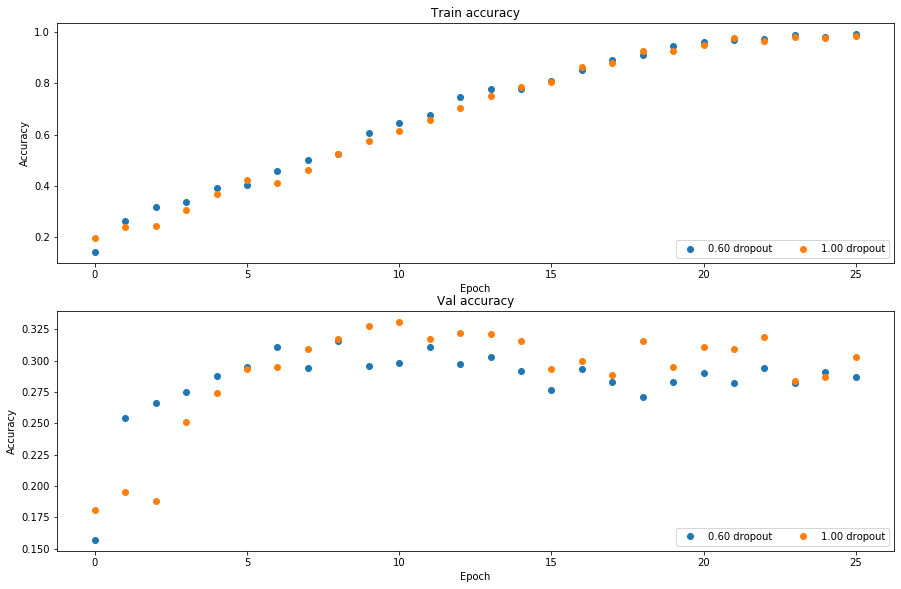

In [0]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
    solver = solvers[dropout]
    train_accs.append(solver.train_acc_history[-1])
    val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
    plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
    plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

## Question

Based off the results of this experiment, is dropout performing regularization?  Explain your answer.

## Answer:
Because dropout can remove the contribution of some points in each step. this results that the network becomes less sensitive to the data at training time. thus it can help to avoid overfitting.    

##### Final part of the assignment

Get over 55% validation accuracy on CIFAR-10 by using the layers you have implemented.  You will be graded according to the following equation:

min(floor((X - 32%)) / 23%, 1) 
where if you get 55% or higher validation accuracy, you get full points.

(Iteration 1 / 1470) loss: 2.302183
(Epoch 0 / 15) train acc: 0.097000; val_acc: 0.102000
(Epoch 1 / 15) train acc: 0.459000; val_acc: 0.449000
(Epoch 2 / 15) train acc: 0.487000; val_acc: 0.487000
(Epoch 3 / 15) train acc: 0.503000; val_acc: 0.501000
(Epoch 4 / 15) train acc: 0.589000; val_acc: 0.524000
(Epoch 5 / 15) train acc: 0.607000; val_acc: 0.533000
(Epoch 6 / 15) train acc: 0.633000; val_acc: 0.539000
(Epoch 7 / 15) train acc: 0.711000; val_acc: 0.550000
(Epoch 8 / 15) train acc: 0.739000; val_acc: 0.564000
(Epoch 9 / 15) train acc: 0.752000; val_acc: 0.539000
(Epoch 10 / 15) train acc: 0.789000; val_acc: 0.566000
(Iteration 1001 / 1470) loss: 0.524199
(Epoch 11 / 15) train acc: 0.810000; val_acc: 0.547000
(Epoch 12 / 15) train acc: 0.862000; val_acc: 0.544000
(Epoch 13 / 15) train acc: 0.885000; val_acc: 0.543000
(Epoch 14 / 15) train acc: 0.892000; val_acc: 0.537000
(Epoch 15 / 15) train acc: 0.935000; val_acc: 0.554000


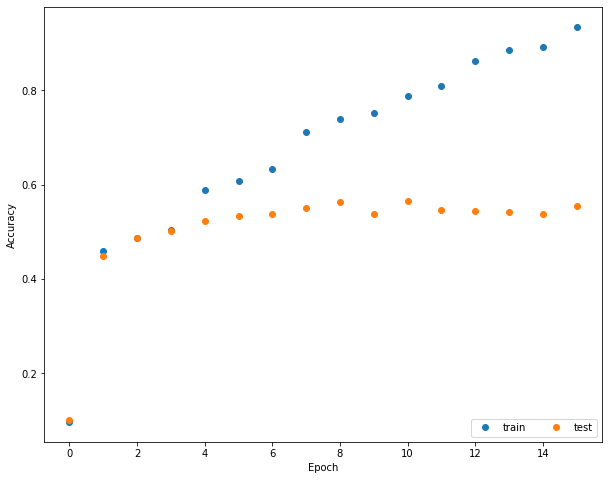

In [0]:
# ================================================================ #
# YOUR CODE HERE:
#   Implement a FC-net that achieves at least 55% validation accuracy
#   on CIFAR-10.
# ================================================================ #
my_data = {
    'X_train': data['X_train'],
    'y_train': data['y_train'],
    'X_val': data['X_test'],
    'y_val': data['y_test'],
}

dropout = 0.60
layer_dims = [500, 500, 500, 500]
weight_scale = 0.01
learning_rate = 1e-3
lr_decay = 0.9

model = FullyConnectedNet(layer_dims, dropout=dropout, use_batchnorm=False, weight_scale=weight_scale)
my_solver = Solver(model, my_data,
                    num_epochs=15, batch_size=500,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': 1e-3,
                    },lr_decay=lr_decay,
                    verbose=True, print_every=1000)

my_solver.train()

plt.plot(my_solver.train_acc_history, 'o', label='train')
plt.plot(my_solver.val_acc_history, 'o', label='test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


In [0]:
x_input = data['X_test']
y_check = data['y_test']
test_a = my_solver.check_accuracy(x_input,y_check)
print("test_acc = %.2f" %test_a)

test_acc = 0.57
